<a href="https://colab.research.google.com/github/ersilia-os/event-fund-ai-drug-discovery/blob/main/notebooks/session2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Session 2: 
In this session, we will use a simple dataset to train a basic Machine Learning Model and understand the steps involved in their development.

*Disclaimer: this pipeline is an example prepared with curated data and should not be reproduced with the student's own datasets. The goal of this workshop is purely academic and does not represent a real research case study.*

## 1. Data Preparation

We will model a critical step in the drug discovery development, **cardiotoxicty due to hERG blockade**. hERG is a potassium channel whose blockage causes prolongued QT intervals and eventually cardiotoxicity, and is one of the major adverse drug reactions that cause compound attrition in the drug discovery pipelines. Therefore, it is essential to identify putative hERG blockers early on the drug discovery cascade.

In this exercise, we will leverage the [Therapeutics Data Commons](https://tdcommons.ai/) database, an open science effort to collect AI-ready datasets for biomedical questions (read more on its [publication](https://arxiv.org/abs/2102.09548)).

The data cleaning steps discussed in Session 1 have already been done for the TDC data, so we can focus directly on the generation of a ML model to predict hERG blocking activity.

In [2]:
%%capture

#TDC can be installed and accessed as a Python package
!pip install PyTDC

In [3]:
# import the hERG dataset, part of the Toxicity data available at TDC
from tdc.single_pred import Tox
data = Tox(name = "hERG")

Downloading...
100%|██████████| 50.2k/50.2k [00:00<00:00, 2.33MiB/s]
Loading...
Done!


In [4]:
#check what is the "data" we have loaded
data

### 1.1 Data Splits
We will start by splitting the data in 3 parts:

*   Train: the portion of the dataset that will be used to train the model
*   Valid: the validation set, which will be used during the modelling to assert and improve the performance of the algorithm
*   Test: a portion of the dataset kept completely separated from the data used to train the model. We will use this to evaluate the final model performance.

Usually, this process is done manually and must ensure that the three datasets are balanced (i.e. have an equal representation of positives and negatives and are representative of all the chemical space). 

For the purpose of the course, we will use the prepared TDC split which already guarantees the above conditions.


In [6]:
split = data.get_split()
split.keys()

dict_keys(['train', 'valid', 'test'])

In [7]:
#we can now separate the compressed dataset in the three sections
train = split["train"]
valid = split["valid"]
test = split["test"]

In [8]:
#we can check how many molecules we have in each set
print(len(train))
print(len(valid))
print(len(test))

458
66
131


In [9]:
#let's explore the data
#by convention, the input (molecules in this case) is named X, and the output (bioactivity) is Y
train.head() 

,Drug_ID,Drug,Y
0,DEMETHYLASTEMIZOLE,Oc1ccc(CCN2CCC(Nc3nc4ccccc4n3Cc3ccc(F)cc3)CC2)cc1,1.0
1,GBR-12909,Fc1ccc(C(OCC[NH+]2CC[NH+](CCCc3ccccc3)CC2)c2cc...,1.0
2,CLOFILIUM PHOSPHATE,CCCCCCC[N+](CC)(CC)CCCCc1ccc(Cl)cc1.CCCCCCC[N+...,1.0
3,FLUSPIRILENE,O=C1NCN(c2ccccc2)C12CC[NH+](CCCC(c1ccc(F)cc1)c...,1.0
4,VANOXERINE HYDROCHLORIDE,Fc1ccc(C(OCCN2CCN(CCCc3ccccc3)CC2)c2ccc(F)cc2)cc1,1.0


In [10]:
#we can check the number of positives and negatives in the train set
print(len(train[train["Y"]==0])) #not cardiotoxic
print(len(train[train["Y"]==1])) # cardiotoxic

148
310


### 1.2 Data Visualization
Finally, before moving onto model training, we can leverage the Python Package RdKit, the largest open source toolbox for chemioinformatics, to explore a bit more the chemical structures of our data

In [11]:
%%capture
#we first need to install rdkit in Google Colab and import the packages of interest
!pip install rdkit

from rdkit import Chem
from rdkit.Chem import Draw

In [12]:
#we select a list of smiles

smiles = train["Drug"][449:] # from the 449 to the end of the dataset
smiles

449    CC1=C(CC(=O)[O-])c2cc(F)ccc2/C1=C\c1ccc(S(C)=O...
450            CNS(=O)(=O)Cc1ccc2c(c1)C(CC[NH+](C)C)C=N2
451                   C[N+]1=NN=C2C(C(N)=O)=NC=[N+]2C1=O
452                    CC(C)(C)[NH2+]CC(O)c1cc(O)cc(O)c1
453             CC12CCC3C(CCC4=CC(=O)C=CC43C)C1CCC(=O)O2
454                  O=C1CCC(N2C(=O)c3ccccc3C2=O)C(=O)N1
455       O=P([O-])([O-])C(Sc1ccc(Cl)cc1)P(=O)([O-])[O-]
456                         Clc1ccc2nsnc2c1NC1=[NH+]CCN1
457      Cc1ccc(C(=O)c2cc(O)c([O-])c([N+](=O)[O-])c2)cc1
Name: Drug, dtype: object

In [13]:
#convert the smiles to RdKit Molecules (not readable by humans)
mols = [Chem.MolFromSmiles(smi) for smi in smiles]
mols[0] #again, we can check what is the "mols" we have created

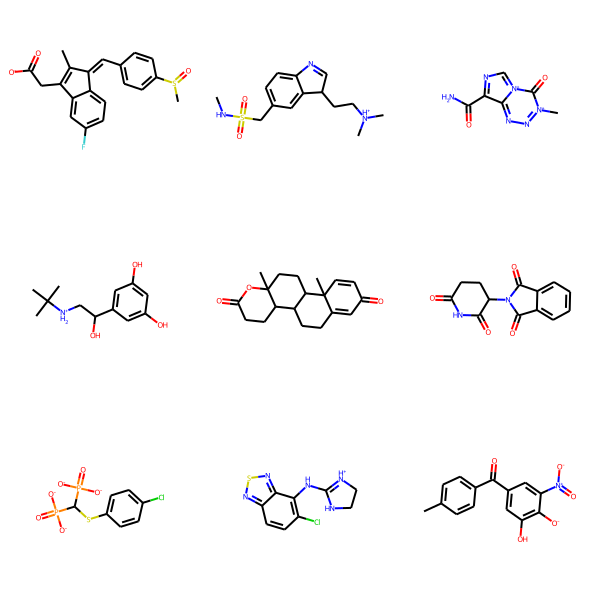

In [14]:
#use the Draw function to visualise the molecules
Draw.MolsToGridImage(mols)

## 2. Molecule Featurization

To train an ML model, we need to be able to pass the molecules to the computer in a format that the computer can understand. That is, numerical vectors or images.

In this case, we will use the Chemical Checker to create signatures encompassing not only structural characteristics but also the bioactivity profile of the molecules.

In [5]:
%%capture
#first, we install the signaturizer and import it
!pip install signaturizer
from signaturizer import Signaturizer

sign = Signaturizer("GLOBAL")

In [15]:
#we then convert the smiles (X)
X_train = sign.predict(train["Drug"]).signature

Parsing SMILES: 458it [00:00, 1688.97it/s]
Generating signatures: 100%|██████████| 4/4 [00:08<00:00,  2.11s/it]


In [16]:
# we can see how a molecule in the train set has been converted to a vector
X_train[0] #0 indicates the first molecule in the list

array([-0.09308645,  0.09305048, -0.09294817, ..., -0.05613168,
       -0.1379203 ,  0.05799835], dtype=float32)

In [17]:
#we also convert the Validation and Test sets
X_valid = sign.predict(valid["Drug"]).signature
X_test = sign.predict(test["Drug"]).signature

Parsing SMILES: 66it [00:00, 3787.86it/s]
Generating signatures: 100%|██████████| 1/1 [00:00<00:00,  1.80it/s]
Parsing SMILES: 131it [00:00, 4391.38it/s]
Generating signatures: 100%|██████████| 2/2 [00:01<00:00,  1.81it/s]


In [18]:
#finally, we need to prepare the outputs (Y), creating three lists:
Y_train = list(train["Y"])
Y_valid = list(valid["Y"])
Y_test = list(test["Y"])

## 3. Supervised Machine Learning

We will use the SciKit-Learn Python package to train an ML model based on a Random Forest algorithm. In this case, since the data is already binarized (0 and 1 for inactive and active, instead of continuous experimental results like IC50) we will train a Classifier.

In [19]:
%%capture

#install scikit-learn (sklearn) and import the RandomForest function
!pip install sklearn
from sklearn.ensemble import RandomForestClassifier

In [20]:
#in ML, the training of a model is called "fitting" the model to the data (the molecules and outputs of the Train set)

clf = RandomForestClassifier()
clf.fit(X_train, Y_train)

RandomForestClassifier()

### 3.1 Model Evaluation
To understand whether a model is performing correctly or not, we have several measures. Here, we will use two of them:


*   Confusion matrices: a table that indicates how many molecules were correctly classified by the model and how many were misclassified.
*   ROC Curve: a probability curve showing the True Positive and False Positive Rates at different classification thresholds.

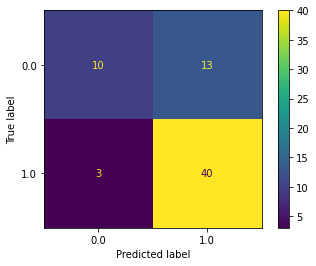

In [21]:
from sklearn.metrics import ConfusionMatrixDisplay as cdm

cdm.from_estimator(clf, X_valid, Y_valid) #we use the validation set to check model performance

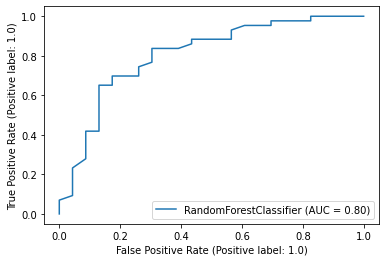

In [22]:
from sklearn.metrics import RocCurveDisplay as rdc

rdc.from_estimator(clf, X_valid, Y_valid) #we use the validation set to check model performance

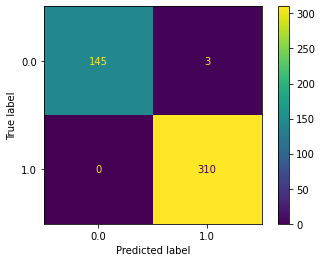

In [23]:
#we can also try to predict the values in the training set and see how good our algorithm does:
cdm.from_estimator(clf, X_train, Y_train)

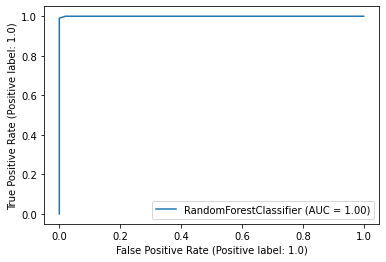

In [24]:
rdc.from_estimator(clf, X_train, Y_train)

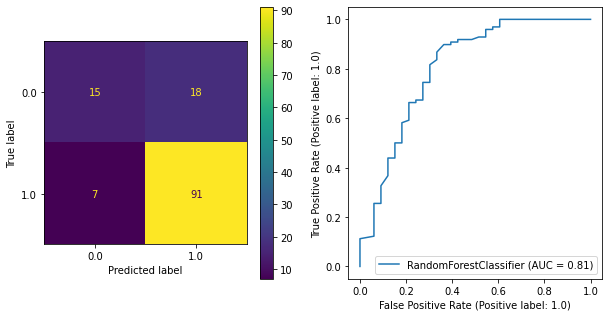

In [32]:
#And the performance on the test data

import matplotlib.pyplot as plt


fig, ax = plt.subplots(1,2, figsize=(10,5))
cdm.from_estimator(clf, X_test, Y_test, ax=ax[0])
rdc.from_estimator(clf, X_test, Y_test, ax = ax[1])